In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import json
import glob
from PIL import Image
from tqdm.notebook import tqdm
from pathlib import Path
from dataclasses import dataclass

import os
import seaborn as sns
import plotly.graph_objs as go

In [2]:
dataset_path = Path('../input/indoor-location-navigation')
os.listdir(dataset_path)

['metadata', 'sample_submission.csv', 'test', 'train']

# utility functions

In [3]:
# functions to process txt data
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray
        
def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
            
        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
            
        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])
            
    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [4]:
def visualize_trajectory(trajectory, floor_plan_filename, width_meter, height_meter, title=None, mode='lines + markers + text', show=False):
    """
    Copied from from https://github.com/location-competition/indoor-location-competition-20/blob/master/visualize_f.py

    """
    fig = go.Figure()

    # add trajectory
    size_list = [6] * trajectory.shape[0]
    size_list[0] = 10
    size_list[-1] = 10

    color_list = ['rgba(4, 174, 4, 0.5)'] * trajectory.shape[0]
    color_list[0] = 'rgba(12, 5, 235, 1)'
    color_list[-1] = 'rgba(235, 5, 5, 1)'

    position_count = {}
    text_list = []
    for i in range(trajectory.shape[0]):
        if str(trajectory[i]) in position_count:
            position_count[str(trajectory[i])] += 1
        else:
            position_count[str(trajectory[i])] = 0
        text_list.append('        ' * position_count[str(trajectory[i])] + f'{i}')
    text_list[0] = 'Start 0'
    text_list[-1] = f'End {trajectory.shape[0] - 1}'
    
    fig.add_trace(
        go.Scattergl(
            x=trajectory[:, 0],
            y=trajectory[:, 1],
            mode=mode,
            marker=dict(size=size_list, color=color_list),
            line=dict(shape='linear', color='lightgrey', width=3, dash='dash'),
            text=text_list,
            textposition="top center",
            name='trajectory',
        ))

    # add floor plan
    floor_plan = Image.open(floor_plan_filename)
    fig.update_layout(images=[
        go.layout.Image(
            source=floor_plan,
            xref="x",
            yref="y",
            x=0,
            y=height_meter,
            sizex=width_meter,
            sizey=height_meter,
            sizing="contain",
            opacity=1,
            layer="below",
        )
    ])
    
    # configure
    fig.update_xaxes(autorange=False, range=[0, width_meter])
    fig.update_yaxes(autorange=False, range=[0, height_meter], scaleanchor="x", scaleratio=1)
    fig.update_layout(
        title=go.layout.Title(
            text=title or "No title.",
            xref="paper",
            x=0,
        ),
        autosize=True,
        width=800,
        height=  800 * height_meter / width_meter,
        template="plotly_white",
    )

    if show:
        fig.show()

    return fig

def visualize_train_trajectory(path):
    """
    Edited from 
    https://www.kaggle.com/ihelon/indoor-location-exploratory-data-analysis
    """
    _id, floor = path.split("/")[:2]
    
    train_floor_data = read_data_file(f"../input/indoor-location-navigation/train/{path}")
    with open(f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_info.json") as f:
        train_floor_info = json.load(f)

    return visualize_trajectory(
        train_floor_data.waypoint[:, 1:3], 
        f"../input/indoor-location-navigation/metadata/{_id}/{floor}/floor_image.png",
        train_floor_info["map_info"]["width"], 
        train_floor_info["map_info"]["height"],
        f"Visualization of {path}"
    )

# train data

In [5]:
train_sites = os.listdir(dataset_path/"train")
print("unique training site: ", len(set(train_sites)))

unique training site:  204


In [6]:
example_site = os.listdir(dataset_path/"train")[10]
example_site_path = dataset_path/"train"/example_site
print('Floors for example site:', example_site)
print(os.listdir(example_site_path))

Floors for example site: 5cd969b639e2fc0b4afe6db1
['B1', 'F1', 'F4', 'F3', 'F2']


In [7]:
print('Path text files for example floor:')
for i in os.listdir(example_site_path):
    print(i, os.listdir(example_site_path/i))

Path text files for example floor:
B1 ['5d08da465ded320009ea9cf4.txt']
F1 ['5d08ceb8b1253b0008b9765c.txt']
F4 ['5d08d531b1253b0008b97680.txt']
F3 ['5d08d3485ded320009ea9ce3.txt']
F2 ['5d08d0b45ded320009ea9cd5.txt']


In [8]:
text_nums = []
for site in os.listdir(dataset_path/"train"):
    for floor in os.listdir(dataset_path/"train"/site):
        text_nums.append(len(os.listdir(dataset_path/"train"/site/floor)))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

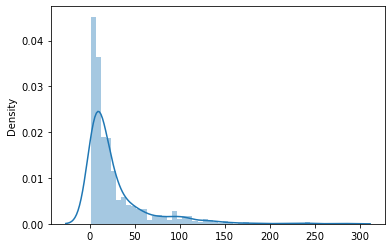

In [9]:
# あるsiteのあるfloorごとにどれだけのファイルがあるか。かなり偏りがある
sns.distplot(text_nums)

In [10]:
floors_per_site = []
for i in os.listdir(dataset_path/"train"): 
    floors_per_site.append(len(os.listdir(dataset_path/"train"/i)))
print(f'There are a total of {sum(floors_per_site)} floors. On average, each site has {np.mean(floors_per_site)} floors')

There are a total of 981 floors. On average, each site has 4.8088235294117645 floors


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

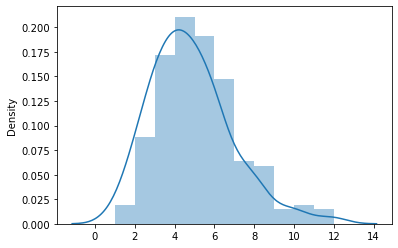

In [11]:
sns.distplot(floors_per_site)

# train trajectory


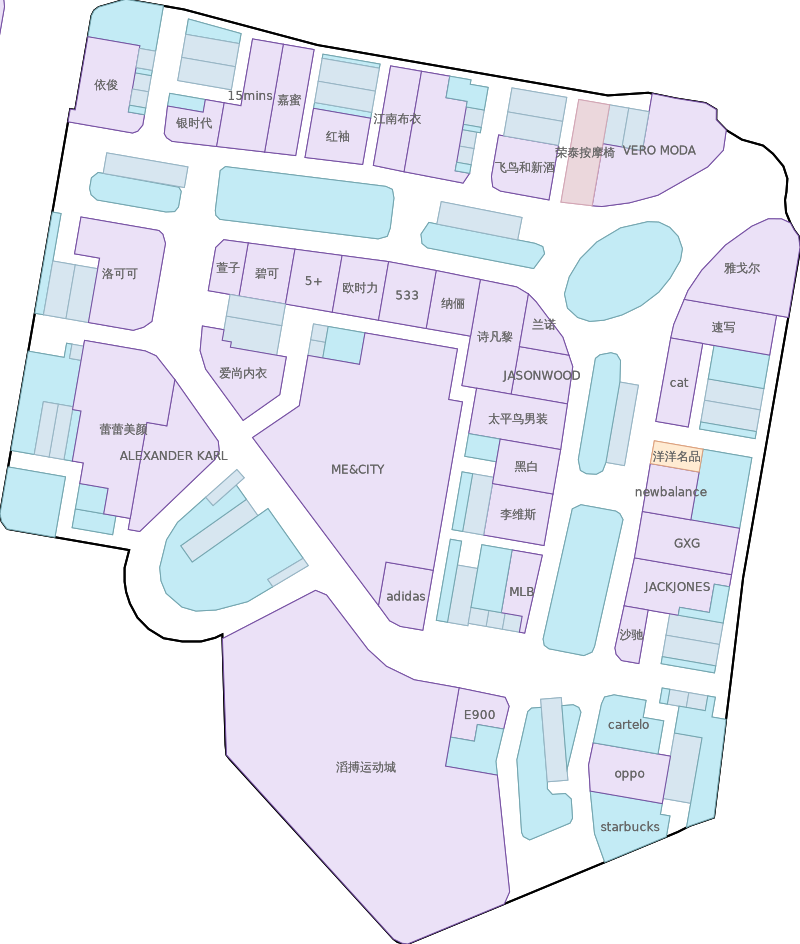

In [12]:
visualize_train_trajectory("5a0546857ecc773753327266/F2/5dccf516c04f060006e6e3c9.txt")

In [13]:
train_trajectory_paths = []
for site in os.listdir(dataset_path/"train"):
    for floor in os.listdir(dataset_path/"train"/site):
        for example in os.listdir(dataset_path/"train"/site/floor):
            path = site+str("/")+floor+str("/")+example
            train_trajectory_paths.append(path)
len(train_trajectory_paths)

26925


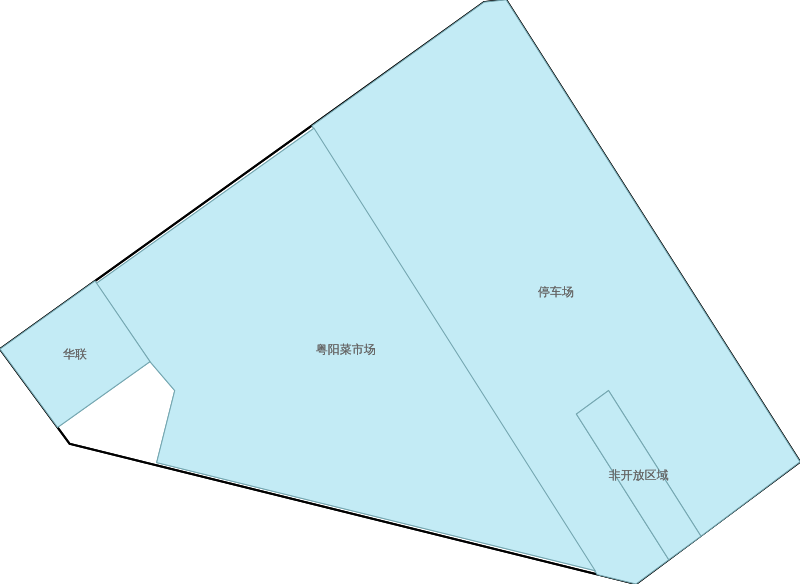

In [14]:
visualize_train_trajectory(train_trajectory_paths[0])


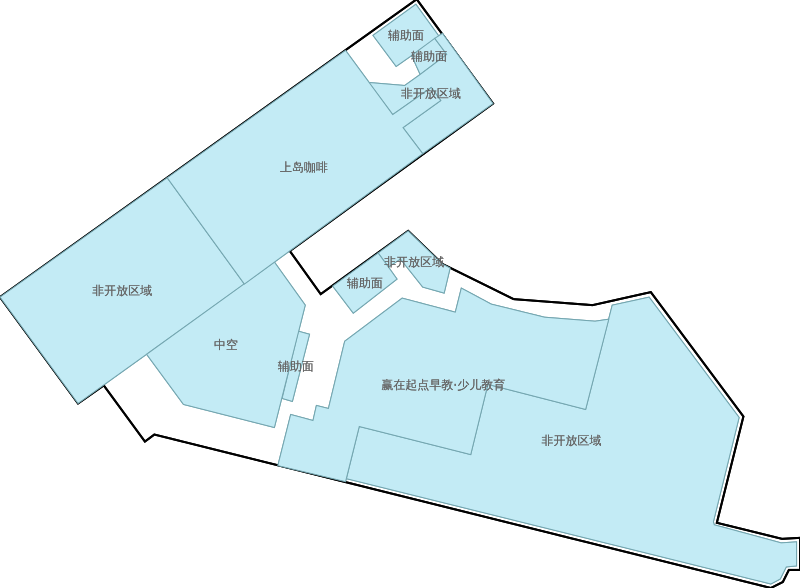

In [15]:
visualize_train_trajectory(train_trajectory_paths[5])

# test data

In [16]:
test_sites = os.listdir(dataset_path/"test")
print("unique test site: ", len(set(test_sites)))

unique test site:  626


In [17]:
# test data only includes path text data
example_site = os.listdir(dataset_path/"test")[10]
print('Floors for example site:', example_site)

Floors for example site: f0d402a465655bfc8ab41242.txt


# metadata

In [18]:
print("unique training site: ", len(os.listdir(dataset_path/"metadata")))

unique training site:  204


In [19]:
set(os.listdir(dataset_path/"metadata")) == set(train_sites)

True

In [20]:
metadata_example_site = os.listdir(dataset_path/"metadata")[0]
metadata_example_site_path = dataset_path/"metadata"/metadata_example_site
metadata_example_floor_path = dataset_path/"metadata"/metadata_example_site/os.listdir(metadata_example_site_path)[0]
print(os.listdir(metadata_example_floor_path))

['geojson_map.json', 'floor_info.json', 'floor_image.png']


In [21]:
os.listdir(metadata_example_site_path)

['B1', 'F3', 'F2']

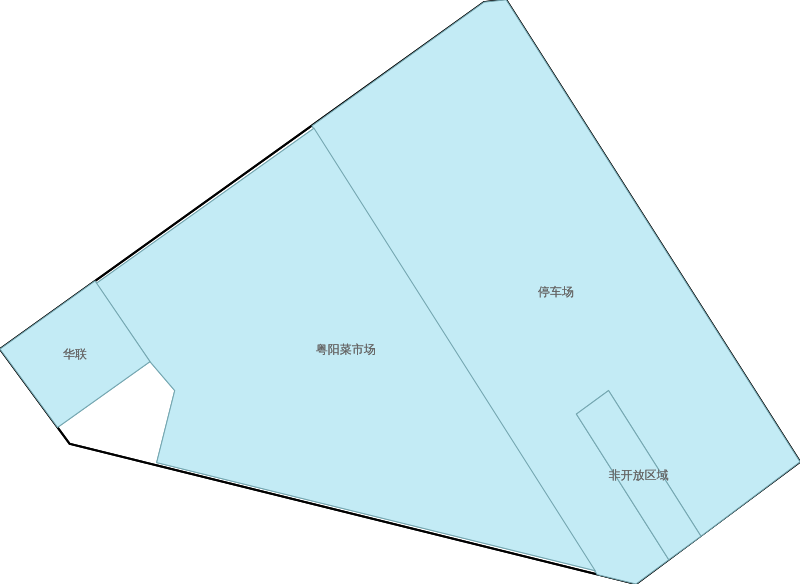

In [22]:
Image.open(metadata_example_floor_path/'floor_image.png')

In [23]:
with open(metadata_example_floor_path/'geojson_map.json') as geojson_map:
    data = json.load(geojson_map)
    geojson_map.close()
print(data)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[13533491.764994005, 3665879.745131374], [13533397.588704797, 3665903.054216612], [13533386.011477754, 3665918.8106623953], [13533466.495469598, 3665976.497656886], [13533470.169012794, 3665976.8883146574], [13533519.038269253, 3665900.059192012], [13533491.764994005, 3665879.745131374]]]]}, 'properties': {'Vr': '000200', 'category': 'floor', 'name': 'B1', 'code': 'TY0011430100100008', 'floor_num': -1, 'type': 'floor'}, 'order': 1, 'crs': {'type': 'link', 'properties': {'href': 'http://spatialreference.org/ref/sr-org/6928/ogcwkt/', 'type': 'ogcwkt'}}}, {'type': 'Feature', 'properties': {'id': '5cd56c0fe2acfd2d33b6b1bd', 'version': '2019-05-10T12:18:23.255Z', 'name': '停车场', 'display': '停车场', 'category': ['5d35734ddb07255e49559b2a', '5d35734edb07255e49559b4b'], 'point': [13533474.024319848, 3665934.903069379], 'points': [], 'doors': []}, 'geometry': {'coordinates': [[[135

In [24]:
with open(metadata_example_floor_path/'floor_info.json') as floor_info:
    data = json.load(floor_info)
    floor_info.close()
print(data)

{'map_info': {'height': 83.04442650447841, 'width': 113.72011124652744}}


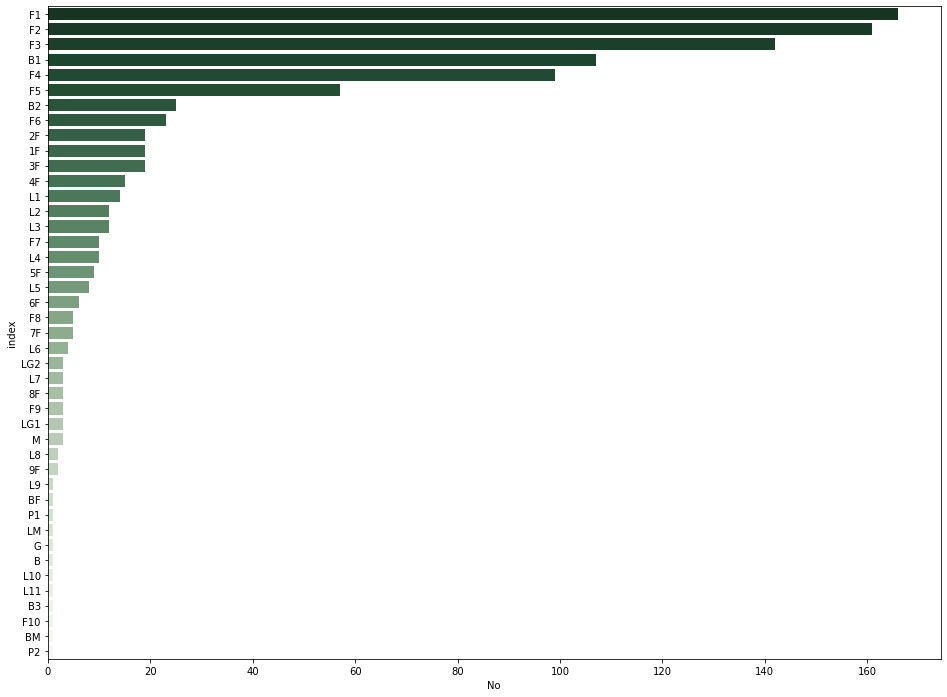

In [25]:
all_floors = glob.glob("../input/indoor-location-navigation/metadata/*/*")
floor_no = []

# Extract only the floor number
for floor in all_floors:
    no = floor.split("/")[5]
    floor_no.append(no)
    
floor_no = pd.DataFrame(floor_no, columns=["No"])
floor_no = floor_no["No"].value_counts().reset_index()
floor_no = floor_no.sort_values("No", ascending=False)

plt.figure(figsize=(16, 12))
ax = sns.barplot(data=floor_no, x="No", y="index", palette="Greens_r",
                 saturation=0.4)

# txt file

In [26]:
example_floor_path = example_site_path/'F1'
example_txt_path = example_floor_path/os.listdir(example_floor_path)[0]
with open(example_txt_path) as example_txt:
    data = example_txt.read()
    example_txt.close()

In [27]:
data[:1000]

'#\tstartTime:1560857917161\n#\tSiteID:5cd969b639e2fc0b4afe6db1\tSiteName:vanke2049海上传奇\tFloorId:5cd969b839e2fc0b4afe6edb\tFloorName:F1\n#\tBrand:HUAWEI\tModel:HWI-AL00\tAndroidName:8.0.0\tAPILevel:26\t\n#\ttype:1\tname:accelerometer-bmi160\tversion:1\tvendor:bosch\tresolution:0.009576807\tpower:0.23\tmaximumRange:78.4532\n#\ttype:4\tname:gyroscope-bmi160\tversion:1\tvendor:bosch\tresolution:1.7453292E-5\tpower:6.1\tmaximumRange:34.906586\n#\ttype:2\tname:akm-akm09918\tversion:1001\tvendor:akm\tresolution:0.0625\tpower:6.8\tmaximumRange:2000.0\n#\tVersionName:v20190612-nightly\tVersionCode:263\t\n1560857917164\tTYPE_WAYPOINT\t11.264449\t50.288967\n1560857917355\tTYPE_ACCELEROMETER\t-0.038307227\t1.8195933\t9.078813\n1560857917355\tTYPE_MAGNETIC_FIELD\t-35.8125\t-12.4375\t-38.625\n1560857917355\tTYPE_GYROSCOPE\t0.044715334\t-0.0649437\t-0.01277581\n1560857917355\tTYPE_ROTATION_VECTOR\t0.04954\t-0.090833\t-0.743541\n1560857917355\tTYPE_MAGNETIC_FIELD_UNCALIBRATED\t-42.0625\t48.875\t-60.8

In [28]:
example_data = read_data_file(example_txt_path)

In [29]:
# 加速度 calibratedとucalibratedのデータあり
print(example_data.acce.shape)
print(example_data.acce_uncali.shape)

# imu: この5項目のデータは長さが一致している
print(example_data.gyro.shape)
print(example_data.gyro_uncali.shape)
print(example_data.magn.shape)
print(example_data.magn_uncali.shape)
print(example_data.ahrs.shape)

print(example_data.wifi.shape) # 数値以外のデータが含まれている
print(example_data.ibeacon.shape) # 数値以外のデータが含まれている
print(example_data.waypoint.shape) # ターゲット

(17244, 4)
(0,)
(17532, 4)
(17532, 4)
(17532, 4)
(17532, 4)
(17532, 4)
(1031, 5)
(288, 3)
(26, 3)


In [30]:
def make_imu(df_):
    temp = np.concatenate([#df_.acce, 
                       #df_.acce_uncali[:, 1:],
                       df_.gyro, #[:, 1:],
                       df_.gyro_uncali[:, 1:],
                       df_.magn[:, 1:],
                       df_.magn_uncali[:, 1:],
                       df_.ahrs[:, 1:],
                      ], axis=1)

    imu_df = pd.DataFrame(temp)

    #'acce_x','acce_y', 'acce_z','acce_uncali_x','acce_uncali_y', 'acce_uncali_z',
    imu_df.columns = ['timestamp',
              'gyro_x','gyro_y', 'gyro_z','gyro_uncali_x','gyro_uncali_y', 'gyro_uncali_z',
              'magn_x','magn_y', 'magn_z','magn_uncali_x','magn_uncali_y', 'magn_uncali_z',
              'ahrs_x','ahrs_y', 'ahrs_z']
    return imu_df

imu_df = make_imu(example_data)
imu_df

,timestamp,gyro_x,gyro_y,gyro_z,gyro_uncali_x,gyro_uncali_y,gyro_uncali_z,magn_x,magn_y,magn_z,magn_uncali_x,magn_uncali_y,magn_uncali_z,ahrs_x,ahrs_y,ahrs_z
0,1.560858e+12,0.044715,-0.064944,-0.012776,0.150116,0.046845,-0.050039,-35.8125,-12.4375,-38.6250,-42.0625,48.8750,-60.8750,0.049540,-0.090833,-0.743541
1,1.560858e+12,-0.007453,-0.190573,0.056426,0.039392,-0.068138,-0.020228,-35.6875,-12.5625,-38.7500,-41.9375,48.7500,-61.0000,0.049386,-0.091587,-0.743605
2,1.560858e+12,0.018099,-0.093689,0.077720,-0.012776,-0.193766,0.048974,-35.6250,-12.6875,-38.3750,-41.8750,48.6250,-60.6250,0.047779,-0.088484,-0.743758
3,1.560858e+12,0.012776,-0.097948,0.074526,0.012776,-0.096883,0.070267,-36.0625,-12.9375,-38.4375,-42.3125,48.3750,-60.6875,0.047155,-0.089273,-0.743261
4,1.560858e+12,-0.004259,-0.135211,0.036198,0.007453,-0.101142,0.067073,-36.3125,-12.5625,-38.2500,-42.5625,48.7500,-60.5000,0.045542,-0.086726,-0.743043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17527,1.560858e+12,-0.004259,0.086237,-0.014905,-0.031940,0.007453,-0.023422,3.1250,-34.5625,-23.9375,-7.0000,24.6875,-51.6875,-0.010509,0.096949,0.994466
17528,1.560858e+12,-0.045780,-0.028746,-0.047909,-0.009582,0.083043,-0.022358,3.0625,-34.8125,-24.0000,-7.0625,24.4375,-51.7500,-0.011832,0.096465,0.994501
17529,1.560858e+12,-0.059620,-0.085172,-0.083043,-0.051103,-0.031940,-0.055362,3.1250,-34.8125,-24.3125,-7.0000,24.4375,-52.0625,-0.011570,0.096008,0.994537
17530,1.560858e+12,-0.004259,-0.027681,-0.085172,-0.064944,-0.088366,-0.090495,3.1875,-34.8750,-24.7500,-6.9375,24.3750,-52.5000,-0.010645,0.094973,0.994609


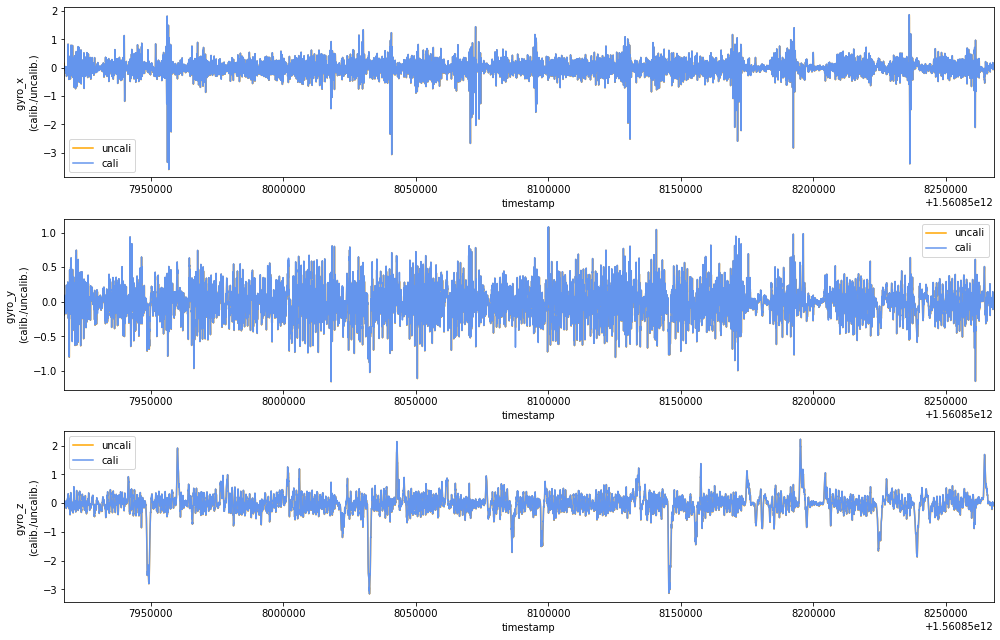

In [31]:
def plot_imu_signals(df, col, uncali = True):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 9))
    ax[0].set_ylabel(f"{col}_x")
    ax[1].set_ylabel(f"{col}_y")
    ax[2].set_ylabel(f"{col}_z")
    if uncali:
        sns.lineplot(x=df.timestamp, y=df[f"{col}_uncali_x"], ax=ax[0], label = 'uncali', color='orange')
        sns.lineplot(x=df.timestamp, y=df[f"{col}_uncali_y"], ax=ax[1], label = 'uncali', color='orange')
        sns.lineplot(x=df.timestamp, y=df[f"{col}_uncali_z"], ax=ax[2], label = 'uncali', color='orange')
        ax[0].set_ylabel(f"{col}_x \n(calib./uncalib.)")
        ax[1].set_ylabel(f"{col}_y \n(calib./uncalib.)")
        ax[2].set_ylabel(f"{col}_z \n(calib./uncalib.)")
    
    sns.lineplot(x=df.timestamp, y=imu_df[f"{col}_x"], ax=ax[0], label='cali', color='cornflowerblue')
    sns.lineplot(x=df.timestamp, y=imu_df[f"{col}_y"], ax=ax[1], label='cali', color='cornflowerblue')
    sns.lineplot(x=df.timestamp, y=imu_df[f"{col}_z"], ax=ax[2], label='cali', color='cornflowerblue')

    for i in range(3):
        ax[i].set_xlim([df.iloc[0]["timestamp"], df.iloc[-1]["timestamp"]])
    plt.tight_layout()
    plt.show()
    
plot_imu_signals(imu_df, 'gyro')

In [32]:
pd.DataFrame(example_data.wifi)

,0,1,2,3,4
0,1560857917802,e469f4405486cba86a3f30c9e1b34e42c1ad2414,0ae7ca56c9e3afa401bc4e808a247fc64e01347e,-89,1560857917746
1,1560857917802,346619ed46f6060ebe056c094cc42235191f7eef,09465f77980c28ef30204a3e6b0053887f693687,-88,1560857917746
2,1560857917802,6923d7b6b086c075092c485e39c95ed48374c014,df95104ca7d54a187edf103d3627d35103acaa53,-83,1560857917746
3,1560857917802,e469f4405486cba86a3f30c9e1b34e42c1ad2414,363dd9da9a175ed8b50cfafe903d41bea20695dd,-66,1560857917746
4,1560857917802,346619ed46f6060ebe056c094cc42235191f7eef,81315d176044fb52425ac4e26d54c2a6df9362b0,-66,1560857917746
...,...,...,...,...,...
1026,1560858249185,346619ed46f6060ebe056c094cc42235191f7eef,81315d176044fb52425ac4e26d54c2a6df9362b0,-84,1560858249108
1027,1560858249185,346619ed46f6060ebe056c094cc42235191f7eef,8deadad8369ea8a4061f239574544d4d11407381,-77,1560858249108
1028,1560858249185,346619ed46f6060ebe056c094cc42235191f7eef,61a2c29d7ba70e0669f334681894773b0cecac74,-79,1560858249108
1029,1560858249185,9602436370a46fe8da2d3e20b912731590c7cc21,c65f4dfb28c0694c778a00405794a9406e8725bc,-56,1560858249108


In [33]:
pd.DataFrame(example_data.ibeacon)

,0,1,2
0,1560857919847,4e9d3569a79dcbd102831d1bd587aa4e868ae797_b567e...,-88
1,1560857922677,4e9d3569a79dcbd102831d1bd587aa4e868ae797_b567e...,-80
2,1560857924164,4e9d3569a79dcbd102831d1bd587aa4e868ae797_b567e...,-78
3,1560857924423,89cb11b04122cef23388b0da06bd426c1f48a9b5_cf6a3...,-87
4,1560857925557,4e9d3569a79dcbd102831d1bd587aa4e868ae797_b567e...,-78
...,...,...,...
283,1560858262218,4e9d3569a79dcbd102831d1bd587aa4e868ae797_29b4d...,-91
284,1560858263908,0e570c3406b79266b7ada12e3b9314e7bb9dde3e_8c08e...,-87
285,1560858264289,89cb11b04122cef23388b0da06bd426c1f48a9b5_cf6a3...,-74
286,1560858265697,4e9d3569a79dcbd102831d1bd587aa4e868ae797_c2172...,-90


In [34]:
pd.DataFrame(example_data.waypoint)

,0,1,2
0,1.560858e+12,11.264449,50.288967
1,1.560858e+12,21.161896,52.673100
2,1.560858e+12,28.273113,49.826385
3,1.560858e+12,32.945915,51.353950
4,1.560858e+12,28.273113,49.826385
5,1.560858e+12,31.577076,36.969822
6,1.560858e+12,43.688923,34.877235
7,1.560858e+12,47.790592,28.802750
8,1.560858e+12,66.243870,33.592953
9,1.560858e+12,69.550220,25.261375


# test txt file

In [35]:
test_files = os.listdir(dataset_path/'test')
for i in tqdm(range(len(test_files))):
    test_data = read_data_file(dataset_path/'test'/test_files[i])
    make_imu(test_data)
    #acce_shape.append(test_data.acce.shape)
    #acce_uncali_shape.append(test_data.acce_uncali.shape)
    #gyro_shape.append(test_data.gyro.shape)
    #gyro_uncali_shape.append(test_data.gyro_uncali.shape)
    #magn_shape.append(test_data.magn.shape)
    #magn_uncali_shape.append(test_data.magn_uncali.shape)
    #ahrs_shape.append(test_data.ahrs.shape)
    #wifi_shape.append(test_data.wifi.shape)
    #ibeacon_shape.append(test_data.ibeacon.shape)

  0%|          | 0/626 [00:00<?, ?it/s]

# train and test comparison

In [36]:
set(os.listdir(dataset_path/"test")) & set(os.listdir(dataset_path/"train"))

set()